#NOISE CORRELATION

The following notebook aims to explore the noise structure of a neronal recording. Noise analysis is a commonly used method in computational neuroscience. The biological complexity of neuronal regions can have many distortive effets of clear datas, therefore extracting, separating and analysing a specific noise profile could potentially lead us to better results.
In our case the neuronal data is video sequence abot the hippocampal CA3 region. The video consists of 1000 frames whihc are 512 pixel tall and 512 pixel wide - 1000 x 512 x 512 tensor. To analyze the noise tructure, first we have to extract the noise, then implement spatial cross-correlation between significant number of picture frames and also autocorrelation in time amongst certain time point of randomly selected pixels (100 pixels).

In [ ]:
#@title Importing packages
#Import packages

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

from scipy import stats
from matplotlib.pyplot import figure, show

%matplotlib inline
#%matplotlib widget

In [ ]:
#connect to Google Drive folder where

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading in vivo frames
imgs = np.load("/content/drive/MyDrive/szakdolgozat/In Vivo - Data/0.npy")

In [ ]:
#check the shape

np.shape(imgs)

(1000, 512, 512)

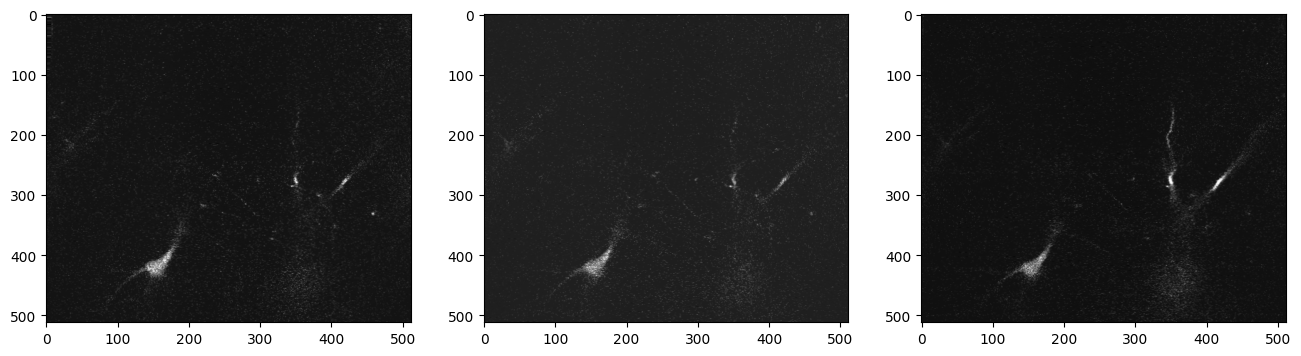

In [ ]:
#quick viusal check

f, axs = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
axs[0].imshow(imgs[100,:,:], cmap='Greys_r', aspect = 'auto')
axs[1].imshow(imgs[200,:,:], cmap='Greys_r', aspect = 'auto')
axs[2].imshow(imgs[300,:,:], cmap='Greys_r', aspect = 'auto')

###Autocorrelation in space


In [ ]:
#calculating the mean

ave_im = np.mean(imgs, axis=0)

We can assume that subtracting the mean image from a given frame would return the noise profile of that frame. Based on this assumption, in the following code cell we subtract the ave_im variable from 100 randomly selected pictures, then put the results into an empty list.

In [ ]:
#list of random pictures

np.random.seed(12)

image_count = 100

random_numbers = np.random.choice(1000,image_count,False)

asd_list = [ imgs[random_numbers[x],:,:] - ave_im for x in range(image_count)]

In [ ]:
#copying the list for further use

imgs_list = asd_list.copy()

In [ ]:
#creating an empty matrix of 61x61 zeros for the function in the next cell

sp_acorr = np.zeros((61, 61))

In the next code cell I defined a function which measures correlation between a given reference image (input image of the function) and its copy that is shifted with 60 pixel units in upper-right diagonal direction. Within the function, first I define a 60x60 matrix with zeros only. Then, I define a nested for loop which shifts the input image that is initialized with position M[50:450] x N[50:450] of the original input image - 512 x 512. In the last step the for loop fill up the predefined empty matrix with the 60 x 60 correlational coefficients, then it takes the average of the whole resulting in one correaltional matrix.

Correlational coefficient: 
\begin{align}
        r = \frac{\sum_{i}(x_i-x̄)*(y_i-\bar{y})} {σ_x*\sigma_y}
    \end{align}


In [ ]:
#correlation function

def func_corr(pic):
    sp_corr = np.zeros((61, 61))
    for i in np.arange(-30, 30):
        for j in np.arange(-30, 30):

          p1 = 50+i
          p1_ = 450+i
          p2 = 50+j
          p2_ = 450+j
          ref_im = pic[50:450,50:450].flatten()
          sec_im = pic[p1:p1_,p2:p2_].flatten()

          m1 = np.mean(ref_im)
          m2 = np.mean(sec_im)
          sd1 = np.std(ref_im)
          sd2 = np.std(sec_im)


          sp_corr[i+30, j+30] = np.mean((ref_im - m1) * (sec_im - m2) / (sd1 * sd2))

    return(sp_corr)

In [ ]:
#iterating funcacorr() over the list
#new_list = [funcacorr(x) for x in imgs_list]

new_imgs_list = []
i = 0
for x in imgs_list:
  print("Calculating %s th image" % i)
  i += 1
  new_imgs_list.append(func_corr(x))


Calculating 0 th image
Calculating 1 th image
Calculating 2 th image
Calculating 3 th image
Calculating 4 th image
Calculating 5 th image
Calculating 6 th image
Calculating 7 th image
Calculating 8 th image
Calculating 9 th image
Calculating 10 th image
Calculating 11 th image
Calculating 12 th image
Calculating 13 th image
Calculating 14 th image
Calculating 15 th image
Calculating 16 th image
Calculating 17 th image
Calculating 18 th image
Calculating 19 th image
Calculating 20 th image
Calculating 21 th image
Calculating 22 th image
Calculating 23 th image
Calculating 24 th image
Calculating 25 th image
Calculating 26 th image
Calculating 27 th image
Calculating 28 th image
Calculating 29 th image
Calculating 30 th image
Calculating 31 th image
Calculating 32 th image
Calculating 33 th image
Calculating 34 th image
Calculating 35 th image
Calculating 36 th image
Calculating 37 th image
Calculating 38 th image
Calculating 39 th image
Calculating 40 th image
Calculating 41 th image
Ca

In the following code, first I fill up another 60 x 60 all-zeros matrix with the each of the previously calculated correlational matrix by using a nested for loop. This results in a 60 x 60 x 100 tensor with the correalational matrices of the randomly selected frames. Secondly,  I use another nested for loop for taking the averge, hence I can extract average range of the noise shift during the recording. In this particular case, it means that if the range is small the noise structure is free any random movements or inteferences that can affect the neuronal recording.

In [ ]:
spatial_cor_mean_per_frames = []
for i in range(100):
 spatial_cor_mean_per_frames.append(np.mean(new_imgs_list[i]))

len(spatial_cor_mean_per_frames)

100

Correlation histogram of average correlation of each noise frame with its translative offset.


Text(0, 0.5, 'Number of correlational coeffs.')

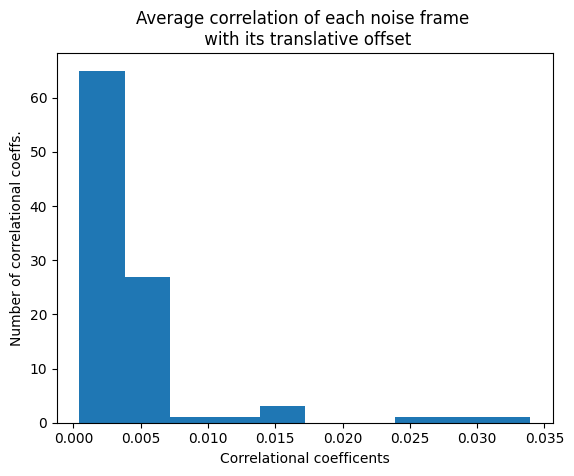

In [ ]:
plt.hist(spatial_cor_mean_per_frames)
plt.title('Average correlation of each noise frame \n with its translative offset')
plt.xlabel('Correlational coefficents')
plt.ylabel('Number of correlational coeffs.')

In [ ]:
scmpf = np.array(spatial_cor_mean_per_frames)
max(scmpf)

0.03395038772520569

In [ ]:

avg_spatial_noise = np.zeros((61,61))

for k in range(len(new_imgs_list)):
  for x in range(61):
    for y in range(61):
      avg_spatial_noise[x][y] = avg_spatial_noise[x][y] + new_imgs_list[k][x][y] # vagy += (hozzáadjuk 0:100 irányban)
for x in range(61):
  for y in range(61):
    avg_spatial_noise[x][y] = avg_spatial_noise[x][y] / 100
print(np.shape(avg_spatial_noise))

(61, 61)


If I print the average of the the prevoiusly returned correlational matrix, we can see that the noise movement is failry low during the recording. Hence, it wil not effect the data analysis.

In [ ]:
print(np.mean(avg_spatial_noise))

0.004176314565980504


Next, I plot a random frame, a random noise frame, the mean image of the recording and the averge noise correlation matrix.

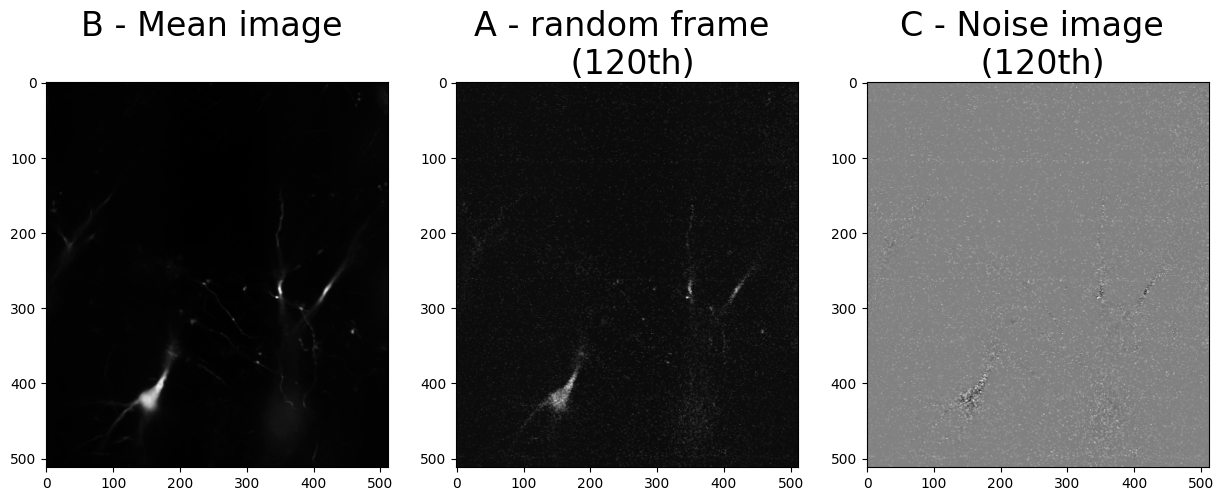

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(ave_im, cmap='Greys_r', aspect = 'auto')
axs[0].title.set_text('B - Mean image \n')
axs[0].title.set_size(24)
axs[1].imshow(imgs[120,:,:], cmap='Greys_r', aspect = 'auto')
axs[1].title.set_text('A - random frame \n (120th)')
axs[1].title.set_size(24)
axs[2].imshow(imgs[120,:,:] - ave_im, cmap='Greys_r', aspect = 'auto')
axs[2].title.set_text('C - Noise image \n (120th)')
axs[2].title.set_size(24)


Correlation peak:

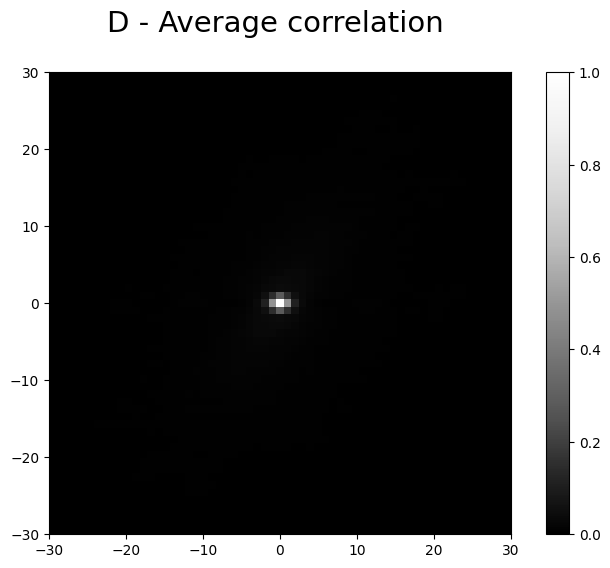

In [ ]:
plt.figure(figsize=(9,6))

z = plt.imshow(avg_spatial_noise, extent=[-30,30,-30,30],cmap='Greys_r')
plt.title('D - Average correlation \n', fontsize = 21)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

f.colorbar(z, orientation='vertical')
plt.show()

Let us plot the correlation decay.Correlation decay shows the extent how correlation decreases meanwhile the distance (Euclidean distance) from the centre pixel (peak pixel) increases.

In [ ]:
import math

In [ ]:
centre = np.array(np.where(avg_spatial_noise == 1))
centre = centre.reshape(2*1)

In [ ]:
centre

array([30, 30])

In [ ]:
distances = np.zeros(3721)
dist_corrcoeffs = np.zeros(3721)

k = 0
for y in range(0, avg_spatial_noise.shape[0]):  #looping through each rows
     for x in range(0, avg_spatial_noise.shape[1]): #looping through each column
          distances[k] = math.dist([x, y],centre)
          dist_corrcoeffs[k] = avg_spatial_noise[x, y]
          k = k + 1

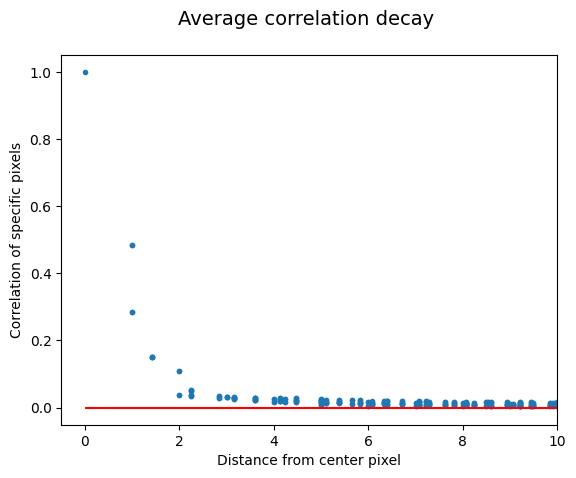

In [ ]:
plt.plot(distances, dist_corrcoeffs, '.')
plt.title('Average correlation decay \n', fontsize = 14)
plt.xlabel('Distance from center pixel')
plt.ylabel('Correlation of specific pixels')
plt.xlim(-.5, 10)
plt.hlines(0, 0, 10, color='r')

In [ ]:
dist_corrcoeffs[np.flatnonzero(distances == 1)]

array([0.48590431, 0.28484734, 0.28476804, 0.48588848])

As we can see the the avergae noise movement is approximately 5 pixel units, which is quite low, nevertheless recording clear neuronal activity in CA3 region can be quite challenging.

###Autocorrelation in time

In the following section I whether there is a corretion in time amongst randomly selected pixels. Correlation in this case would indicate that a observed time point in the past regarding a certain pixel (i.e.: 360.,300) has in influence on the currently observed time point. The code below implements a for cycle wherein 100x100 (from 512x512 options) random pixels selected in time (in the direction of the given tensor - 1000 long array) are called inside sm.tsa.acf function, which is a pecific function of the statsmodel.api Python package for autocorrelation measurement.

Autocorrelation coefficent: 

\begin{align}
        r_k = \frac{\sum_{t=k+1}(y_t-\bar{y})*(y_{t-k}-\bar{y})} {\sum_{t=1}(y_t-\bar{y})^2}
    \end{align}

In [ ]:
# noise_list = np.asarray(imgs)
# #first_pixel_coeffs = sm.tsa.acf(first_pixel, fft=False, nlags=1000) 
# def autocorr(i,j):
#   autocorr_pixels = noise_list[:,i,j]
#   autocorr__mean_coeffs = sm.tsa.acf(autocorr_pixels, fft=False, nlags=1000)
#   return autocorr__mean_coeffs

In [ ]:
pixel_i = np.random.randint(100, 300, 100)
pixel_j = np.random.randint(0, 200, 100)
acf100 = np.zeros((100, 1000))
for i_rep in np.arange(100):
    i = pixel_i[i_rep]
    j = pixel_j[i_rep]
    pixel_t = imgs[:,i,j]
    acf100[i_rep,:] = sm.tsa.acf(pixel_t, fft=False, nlags=1000)

In [ ]:
avg_acf = np.mean(acf100, axis = 0)
len(avg_acf)

1000

Average autocorelation:

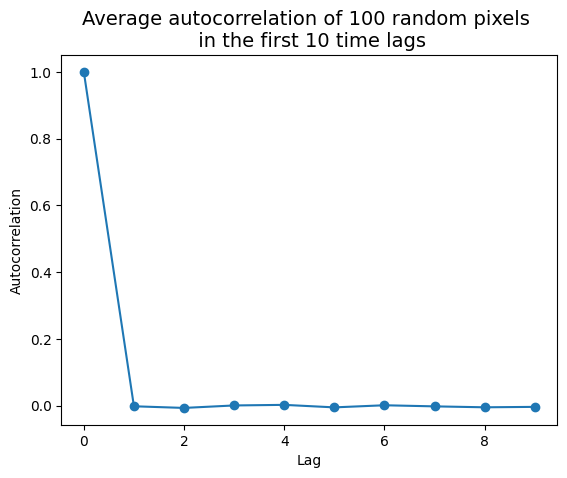

In [ ]:
plt.plot(avg_acf[0:10], '-o')
plt.title('Average autocorrelation of 100 random pixels \n in the first 10 time lags', fontsize = 14)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

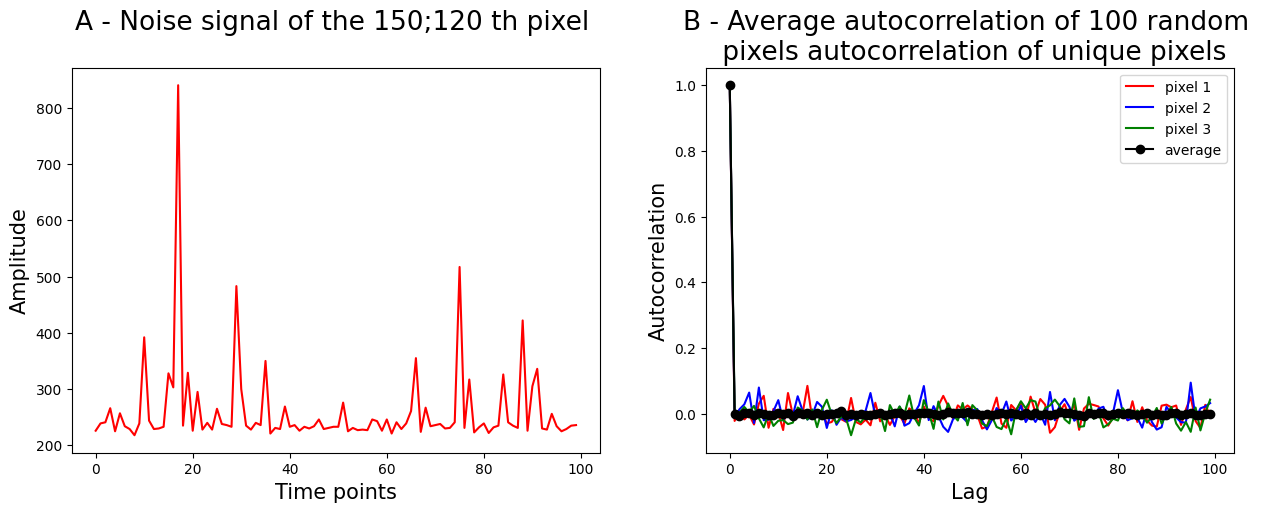

In [ ]:
fig = plt.figure(figsize=(15,5))
lags = np.arange(1000)

rows = 1
columns = 2

#1
fig.add_subplot(rows, columns,  1)
plt.plot(imgs[0:100,pixel_i[0], pixel_j[0]], 'r')
plt.title('A - Noise signal of the 150;120 th pixel \n', fontsize = 19)
plt.xlabel('Time points', fontsize = 15)
plt.ylabel('Amplitude', fontsize = 15)

#2
fig.add_subplot(rows, columns, 2)
plt.plot(lags[0:100], acf100[0,0:100], '-r', label='pixel 1')
plt.plot(lags[0:100], acf100[1,0:100], '-b', label='pixel 2')
plt.plot(lags[0:100], acf100[2,0:100], '-g', label='pixel 3')
plt.plot(lags[0:100], avg_acf[0:100], '-ok', label='average')
plt.title('B - Average autocorrelation of 100 random \n pixels autocorrelation of unique pixels', fontsize = 19)
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Autocorrelation', fontsize = 15)
plt.legend()
plt.show()

As we can see the correlational coefficients in the correlation lags figure below, there is no any significant correlation between certain timepoints of given pixel. This can be interpreted as the following: due to the lack of any significant correlation in space and time between noise pixels, we can assume that noise structure of the neuronal recording has no special charateristic that could infer our later results.